In [1]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

#import pycountry
import re
import string
import logging
import time

from sklearn.preprocessing import MinMaxScaler




In [7]:
#read data
tweets_df= pd.read_pickle('raw_tweets.pkl')  
replies_df= pd.read_pickle('raw_replies.pkl')  
df_twitter=pd.read_csv('twitter_deputies.csv')
genre_speakers=pd.read_csv('genre_speakers.csv')
genre_speakers.fillna(0, inplace=True)
genre_speakers['genre'] = genre_speakers['genre'].map({ 1: 'female', 0:'male'})

In [9]:
#ADD genre
df_twitter=df_twitter.merge(genre_speakers, on='speaker', how='left')

In [25]:
#ADD party and genre
df_twitter = df_twitter.rename(columns={'twitter': 'user_name'})
df_twitter['user_name']=df_twitter['user_name'].str.lower()
tweets_df['user_name']=tweets_df['user_name'].str.lower()
df_ptweets=tweets_df.merge(df_twitter[['party', 'user_name','genre']], on='user_name', how='left')

In [23]:
df_ptweets.head(2)

,user_name,text,year,tweet_id,url,party,genre
0,alexandre_poco,✍🏻 Convido à leitura do artigo de opinião que ...,2021,1475489298027843592,https://twitter.com/Alexandre_Poco/status/1475...,PSD,male
1,alexandre_poco,🗣 No congresso do meu partido a defender um no...,2021,1473000761621508096,https://twitter.com/Alexandre_Poco/status/1473...,PSD,male


In [11]:
#number of tweets per party per year
num_tweets=pd.DataFrame(df_ptweets.groupby(['year','party']).size()).reset_index()
num_tweets.columns=['year','party','num_tweets']
#num of unique accounts per party per year
num_accounts=pd.DataFrame(df_ptweets.groupby(['year','party']).user_name.nunique()).reset_index()
counting_tweets=num_tweets.merge(num_accounts, on=['year','party'], how='left')
#num of tweets per acount per year per party
counting_tweets['year_avg_per_deputy']=counting_tweets.num_tweets/counting_tweets.user_name

counting_tweets.to_csv('tweets_stats.csv')


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '2015'),
  Text(1, 0, '2016'),
  Text(2, 0, '2017'),
  Text(3, 0, '2018'),
  Text(4, 0, '2019'),
  Text(5, 0, '2020'),
  Text(6, 0, '2021')])

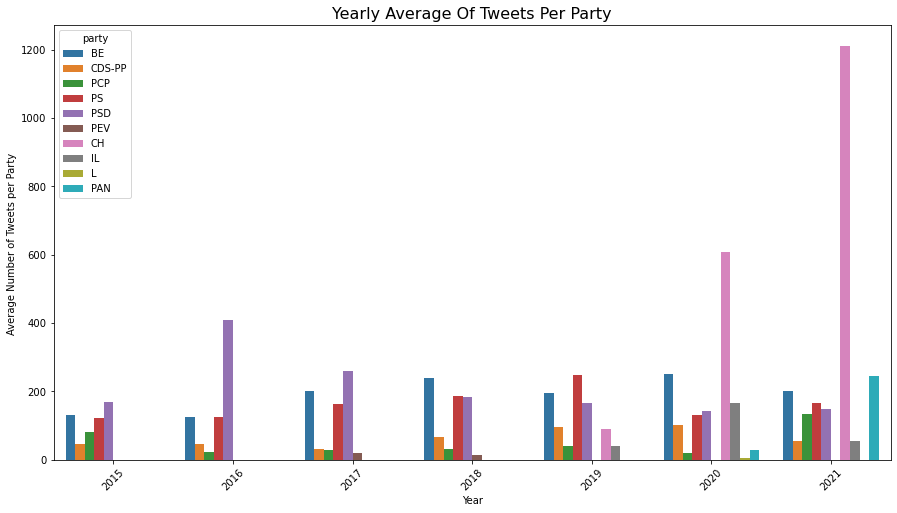

In [12]:
#counting_tweets[['year','party','year_avg_per_deputy']].plot.barh()
plt.figure(figsize=(15,8))
import seaborn as sns

sns.barplot(x='year', y='year_avg_per_deputy', hue='party', data=counting_tweets[['year','party','year_avg_per_deputy']]) 
#add overall title
plt.title('Yearly Average Of Tweets Per Party', fontsize=16)

#add axis titles
plt.xlabel('Year')
plt.ylabel('Average Number of Tweets per Party ')

#rotate x-axis labels
plt.xticks(rotation=45)

In [42]:
df_preplies.head(2)

,user_name,text,year,tweet_id,url,party,genre
0,alexandre_poco,@Alexandre_Poco @Moedas E Rio? Que pensa?,2021,1472991539123134465,https://twitter.com/afc_Tweet19/status/1472991...,PSD,male
1,alexandre_poco,@Alexandre_Poco @JSDPortugal @RuiRioPSD Bases ...,2021,1472729316521881604,https://twitter.com/GuilherminaGon4/status/147...,PSD,male


In [43]:
#ENGAGEMENTS: MASS POLARIZATION
#ADD party and genre

replies_df['user_name']=replies_df['user_name'].str.lower()
df_preplies=replies_df.merge(df_twitter[['party', 'user_name','genre']], on='user_name', how='left')


#number of replies per party per year
num_replies=pd.DataFrame(df_preplies.groupby(['year','party']).size()).reset_index()
num_replies.columns=['year','party','num_replies']

df_eng=num_replies.merge(counting_tweets[['year','party','num_tweets']], on=['year','party'],how='left')
df_eng=df_eng.fillna(0)
df_eng['engagement']=df_eng.num_replies/df_eng.num_tweets
df_eng['engagement'].replace(np.inf, 0, inplace=True)
df_eng['engagement_norm']=(df_eng['engagement'] - df_eng['engagement'].min()) / (df_eng['engagement'].max() - df_eng['engagement'].min()) 
df_eng.to_csv('replies_eng.csv')

In [51]:
df_engG.head()

,term,party,genre,num_replies,user_name
0,13,BE,female,99,2.0
1,13,BE,male,2691,7.0
2,13,CDS-PP,female,7,1.0
3,13,CDS-PP,male,444,3.0
4,13,L,female,2,0.0


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '2015'),
  Text(1, 0, '2016'),
  Text(2, 0, '2017'),
  Text(3, 0, '2018'),
  Text(4, 0, '2019'),
  Text(5, 0, '2020'),
  Text(6, 0, '2021')])

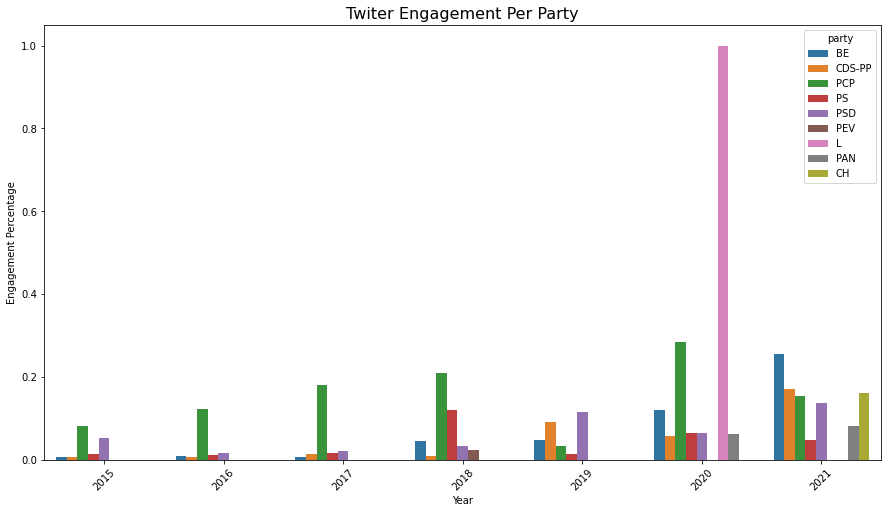

In [44]:
plt.figure(figsize=(15,8))
import seaborn as sns

sns.barplot(x='year', y='engagement_norm', hue='party', data=df_eng[['year','party','engagement_norm']]) 
#add overall title
plt.title('Twiter Engagement Per Party', fontsize=16)

#add axis titles
plt.xlabel('Year')
plt.ylabel('Engagement Percentage')

#rotate x-axis labels
plt.xticks(rotation=45)

In [33]:
# Tweets per genre per term
#add term
df_ptweets['term'] = np.where(df_ptweets.year <=2019, '13', '14')
# genre tweet count by term
genre_tweets=pd.DataFrame(df_ptweets[['term','party','genre']].groupby(['term','party','genre']).size().reset_index())
genre_tweets.to_csv('genre_tweets.csv')

In [99]:
# Engagement per genre per term
#add term
df_preplies['term'] = np.where(df_preplies.year <=2019, '13', '14')

#number of replies per party per term per genre
num_repliesG=pd.DataFrame(df_preplies.groupby(['term','party','genre']).size()).reset_index()
num_repliesG.columns=['term','party','genre', 'num_replies']

#num of unique accounts per party per year
num_accountsG=pd.DataFrame(df_ptweets.groupby(['term','party','genre']).user_name.nunique()).reset_index()
counting_tweetsG=num_repliesG.merge(num_accountsG, on=['term','party','genre'], how='left')

df_engG=num_repliesG.merge(counting_tweetsG[['term','party','genre','user_name']], on=['term','party','genre'],how='left')
df_engG=df_engG.fillna(0)
df_engG['engagement']=df_engG.num_replies/df_engG.user_name
df_engG['engagement'].replace(np.inf, 0, inplace=True)
df_engG['engagement_norm']=(df_engG['engagement'] - df_engG['engagement'].min()) / (df_engG['engagement'].max() - df_engG['engagement'].min()) 
df_engG.to_csv('Greplies_eng.csv')

,user_name,text,year,tweet_id,url,party,term
0,alexandre_poco,✍🏻 Convido à leitura do artigo de opinião que ...,2021,1475489298027843592,https://twitter.com/Alexandre_Poco/status/1475...,PSD,14
1,alexandre_poco,🗣 No congresso do meu partido a defender um no...,2021,1473000761621508096,https://twitter.com/Alexandre_Poco/status/1473...,PSD,14
